In [1]:
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from skimage import io, transform

In [3]:
import pandas as pd
track = pd.read_csv('./genre_small.csv')

In [4]:
y = track.iloc[:,1:2].values
ID = track.iloc[:,0:1].values
y = y[2:,:]
ID = ID[2:,:]

label = {}
for i,j in zip(ID,y):
  label[str(i[0])] = j[0]

In [8]:
print(label['100478'])

Hip-Hop


In [6]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1znqrwOKI_oTQkDSUslEGQoQ9sYvxAXMP',
                                    dest_path='./fma_spec.zip')

In [7]:
!mkdir fma_spec
zip_ref = zipfile.ZipFile('./fma_spec.zip', 'r')
zip_ref.extractall('./fma_spec')
zip_ref.close()

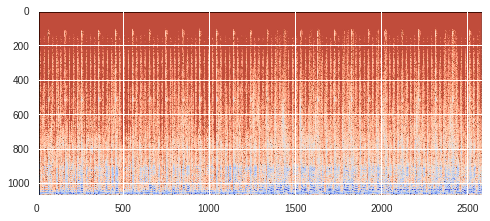

In [0]:
temp = cv2.imread('/content/fma_spec/100478.jpg')
plt.imshow(temp)

In [0]:
def chop_image(path):
  img = cv2.imread(path)
  height, width, channels = img.shape
  
  w = width // 10

  images = []

  for i in range(0,10):
    temp = img[:, (i*w):((i+1)*w), :]
    temp = cv2.resize(temp,(128,128))
    images.append(temp)
  return images

In [0]:
!mkdir chopped1

In [0]:
#create chopped data
path = '/content/fma_spec'
des = '/content/chopped1'
from tqdm import tqdm
for i in tqdm(os.listdir('/content/fma_spec')):
  path1 = os.path.join(path,i)
  temp = chop_image(path1)
  for j in range(0,10):
    image = temp[j]
    p = i[:-4]
    p = p+'_{}'.format(j) + '.png'
    des1 = os.path.join(des , p )
    cv2.imwrite(des1,image)

100%|██████████| 7997/7997 [08:57<00:00, 14.87it/s]


In [0]:
print(len(os.listdir('/content/chopped1')))

79970


In [0]:
import shutil
shutil.make_archive('fma1', 'zip', '/content/chopped1')

'/content/fma1.zip'

In [0]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file1 = drive.CreateFile({"mimeType": "text/csv"})
file1.SetContentFile("/content/fma1.zip")
file1.Upload()

In [2]:
temp = cv2.imread('/content/chopped1/131425_2.png')
print(temp.shape)
#plt.imshow(temp)

NameError: ignored

In [5]:
encoder = {}
encoder['Hip-Hop'] = 0
encoder['Pop'] = 1
encoder['Rock'] = 2
encoder['Experimental'] = 3
encoder['Folk'] = 4
encoder['Instrumental'] = 5
encoder['Electronic'] = 6
encoder['International'] = 7
decoder = {}
decoder[0] ='Hip-Hop' 
decoder[1] = 'Pop'
decoder[2] = 'Rock'
decoder[3] = 'Experimental'
decoder[4] = 'Folk'
decoder[5] = 'Instrumental'
decoder[6] = 'Electronic'
decoder[7] = 'International'

In [0]:
#removing photos without labels
for image in os.listdir('./fma_spec'):
  path = os.path.join('./fma_spec',image)
  file_name = image
  file_name = file_name[:-4]
  file_name = "".join(file_name)
  genre = label.get(file_name,'notfound')
  if genre == 'notfound':
    os.remove(path)

In [6]:
class datagen(Dataset):
  
  def __init__(self,label,image_dir):
    self.img_dir = image_dir
    self.label = label
    self.directory = os.listdir(self.img_dir)
  def __len__(self):
    return len(os.listdir(self.img_dir))
  
  def __getitem__(self,idx):
    file_name = self.directory[idx]
    path = os.path.join(self.img_dir,file_name)
    image = cv2.imread(path)
    image = image/255.0
    file_name = file_name[:-6]
    file_name = "".join(file_name)
    genre = self.label.get(file_name,'notfound')
    if genre == 'notfound':
      print("not found wtf")
    genre = encoder[genre]
    genre = np.asarray(genre)
    return np.asarray(image),genre

In [7]:
datagen_object = datagen(label,'./fma_spec')

In [8]:
test_size = 0.2
valid_size = 0.1
data_len = len(datagen_object)
indices = list(range(data_len))
np.random.shuffle(indices)
split1 = int(np.floor(valid_size * data_len))
split2 = int(np.floor(test_size * data_len))
valid_idx , test_idx, train_idx = indices[:split1], indices[split1:split2] , indices[split2:] 
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(datagen_object, batch_size=64 , sampler=train_sampler)
valid_loader = DataLoader(datagen_object, batch_size=64, sampler=valid_sampler)
test_loader = DataLoader(datagen_object, batch_size=64, sampler=test_sampler)
dataloaders = {'train':train_loader,'val':valid_loader}

In [28]:
resnet5 = resnet50()
num_ftrs = resnet5.fc.in_features
resnet5.fc = nn.Sequential(nn.Linear(num_ftrs,256),nn.ReLU(),nn.Linear(256,8),nn.LogSoftmax(dim=1))
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer_ft = optim.SGD(resnet5.parameters(), lr=0.0001 , momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [37]:
#resnet50.load_state_dict(torch.load('./resnet50/genreweights-0.9658593750000001.h5'))
ct=0
for child in model_ft.children():
    ct += 1
    #print(ct,child)
    
    if ct < 8:
        for param in child.parameters():
            #pass
            param.requires_grad = False

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet5.load_state_dict(torch.load('./resnet50/genreweights-0.9658593750000001.h5'))
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    model.to(device)
    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    i = 0
    for epoch in range(num_epochs):
      print('Epoch:',epoch)
      
      for phase in ['train', 'val']:
        if phase == ' train':
            scheduler.step()
            model.train()  
        else:
            model.eval()   
            
        running_loss = 0.0
        running_corrects = 0
        total = 0
        
        for inputs, labels in dataloaders[phase]:    
            labels = labels.to(device)
            #labels = labels.type(torch.cuda.FloatTensor)
            inputs = inputs.view(inputs.shape[0],3,128,128)
            inputs = inputs.to(device)
            inputs = inputs.type(torch.cuda.FloatTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                #preds = preds.reshape(preds.size(0),-1)
                loss = criterion(outputs, labels)
               # print(preds)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics 
            running_loss += loss.item() * inputs.size(0)
            #print(labels.shape)
            a = preds.data
            
            running_corrects = running_corrects + torch.sum(preds == labels.data)
            total += labels.size(0)
            i = i+1
            #if(i%100==0):
            #  print('loss :{} accuracy : {}'.format(running_loss/(i*512),running_corrects.double()/(total)))
              
              #print(i)
            
        epoch_loss = running_loss/(len(dataloaders[phase])*64)
        epoch_acc = running_corrects.double()/(len(dataloaders[phase])*64)
        torch.save(model.state_dict(), './resnet50/genreweights-{}.h5'.format(epoch_acc))
          #writer.add_scalar('./sanchit/scalar1', epoch_loss , epoch)
        print('{} Loss: {:.4f} , acc: {:.4f}'.format(phase, epoch_loss , epoch_acc))
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    best_acc = epoch_acc
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

model_ft = train_model(resnet5, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=1)

Epoch: 0
train Loss: 0.1238 , acc: 0.9663
val Loss: 0.1534 , acc: 0.9576
Training complete in 10m 29s
Best val Acc: 0.957625


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test_model(model, test_loader,criterion,batch_size):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    i = 0
    running_loss=0.0
    running_corrects = 0
    total = 0
    for inputs, labels in test_loader:    
        labels = labels.to(device)
            #labels = labels.type(torch.cuda.FloatTensor)
        inputs = inputs.view(inputs.shape[0],3,128,128)
        inputs = inputs.to(device)
        inputs = inputs.type(torch.cuda.FloatTensor)

            # zero the parameter gradients
        #optimizer.zero_grad()
        model.eval()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects = running_corrects + torch.sum(preds == labels.data)
        total += labels.size(0)
    epoch_loss = running_loss/(len(test_loader)*batch_size)
    epoch_acc = running_corrects.double()/(len(test_loader)*batch_size)
    print('Test loss: {} , Test accuracy: {}'.format(epoch_loss,epoch_acc))

In [48]:
test_model(resnet5,test_loader, criterion ,64)

Test loss: 0.1471940102726221 , Test accuracy: 0.9575


In [27]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model